In [ ]:
"""
Semi-Supervised Functional Autoencoder (FAE) with ARIMA/VAR forecasting
=======================================================================

- Loads El Nino ERSST data (optional helper).
- Builds functional bases (Bspline/Fourier or custom).
- Trains a semi-supervised FAE (reconstruction + smoothness + classification).
- Extracts the coefficient layer (decoder output) as b_t in R^{M(O)}.
- Fits ARIMA (per coefficient) OR VAR on {b_{1,m},..., b_{n,m}} across samples.
- Forecasts future coefficients \tilde{b}_{n+h}.
- Reconstructs future curves via the fixed decoder basis layer.

Author: (adapted for ARIMA/VAR layer by ChatGPT)
"""

# ============================================================
# Imports
# ============================================================
import os
from typing import Callable, Dict, Optional, Tuple

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

# statsmodels for ARIMA / VAR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR



# Reproducibility
def set_seed(seed: int = 743) -> None:
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


# ============================================================
# Data loading (El Nino ERSST)
# ============================================================
def load_elnino_data(data_dir: str = "Dataset"):
    """
    Load and preprocess El Nino ERSST data, matching original script behavior.

    Parameters
    ----------
    data_dir : str
        Directory containing 'ElNino_ERSST.csv',
        'ElNino_ERSST_tpts.csv' and 'ElNino_ERSST_label.csv'.

    Returns
    -------
    x : torch.Tensor, shape [n_curves, n_time]
        Centered functional data (each row is one curve).
    label : np.ndarray, shape [n_curves]
        Integer labels (original coding from CSV, e.g. {1,2,3,4}).
    tpts : torch.Tensor, shape [n_time]
        Rescaled time grid in [0,1].
    """
    x_raw = pd.read_csv(os.path.join(data_dir, "ElNino_ERSST.csv"))
    tpts_raw = pd.read_csv(os.path.join(data_dir, "ElNino_ERSST_tpts.csv"))
    label_table = pd.read_csv(os.path.join(data_dir, "ElNino_ERSST_label.csv"))

    label = label_table.x.to_numpy()
    time_grid = np.array(tpts_raw).flatten()

    # Prepare tensor data
    x_np = np.array(x_raw).astype(float)
    x = torch.tensor(x_np, dtype=torch.float32)

    # Center each time point (feature-wise mean)
    x_mean = torch.mean(x, dim=0)
    x = x - x_mean

    # Rescale timestamp to [0,1]
    tpts_np = np.array(tpts_raw, dtype=float)
    tpts_rescale = (tpts_np - tpts_np.min()) / np.ptp(tpts_np)
    tpts = torch.tensor(tpts_rescale.flatten(), dtype=torch.float32)

    return x, label, tpts


# ============================================================
# Basis construction (pure Python: B-spline / Fourier)
# ============================================================

def _bspline_basis_matrix(t: np.ndarray, n_basis: int, degree: int = 3) -> np.ndarray:
    """
    Uniform B-spline basis on [min(t), max(t)], implemented from scratch.

    Parameters
    ----------
    t : np.ndarray, shape [n_time]
    n_basis : int
    degree : int (default 3 = cubic)

    Returns
    -------
    B : np.ndarray, shape [n_time, n_basis]
    """
    t = np.asarray(t, float).ravel()
    t0, t1 = t.min(), t.max()
    if t1 > t0:
        u = (t - t0) / (t1 - t0)  # map to [0,1]
    else:
        u = np.zeros_like(t)

    m = n_basis
    p = degree
    # number of interior knots
    n_int = max(m - p - 1, 0)

    if n_int > 0:
        # uniform interior knots in (0,1)
        interior = np.linspace(0, 1, n_int + 2)[1:-1]
    else:
        interior = np.array([], dtype=float)

    # Knot vector: p+1 zeros, interior, p+1 ones
    knots = np.concatenate((np.zeros(p + 1), interior, np.ones(p + 1)))
    assert len(knots) - p - 1 == m

    n = len(u)
    B = np.zeros((m, n))

    # degree 0 basis functions
    for i in range(m):
        left, right = knots[i], knots[i + 1]
        if i == m - 1:
            mask = (u >= left) & (u <= right)
        else:
            mask = (u >= left) & (u < right)
        B[i, mask] = 1.0

    # Cox–de Boor recursion to higher degree
    for k in range(1, p + 1):
        B_new = np.zeros_like(B)
        for i in range(m):
            left_denom = knots[i + k] - knots[i]
            right_denom = knots[i + k + 1] - knots[i + 1] if i + 1 < m else 0.0

            term1 = 0.0
            term2 = 0.0
            if left_denom > 0:
                term1 = ((u - knots[i]) / left_denom) * B[i]
            if right_denom > 0 and i + 1 < m:
                term2 = ((knots[i + k + 1] - u) / right_denom) * B[i + 1]

            B_new[i] = term1 + term2
        B = B_new

    return B.T  # [n_time, n_basis]


def _fourier_basis_matrix(t: np.ndarray, n_basis: int) -> np.ndarray:
    """
    Simple Fourier basis on [min(t), max(t)] with n_basis columns.

    Basis columns:
    - k=0: constant 1
    - k odd: sin(freq * scaled_t)
    - k even: cos(freq * scaled_t)
    """
    t = np.asarray(t, float).ravel()
    t0, t1 = t.min(), t.max()
    if t1 > t0:
        tau = (t - t0) / (t1 - t0) * 2 * np.pi
    else:
        tau = np.zeros_like(t)

    cols = []
    for k in range(n_basis):
        if k == 0:
            cols.append(np.ones_like(t))
        elif k % 2 == 1:
            freq = (k + 1) // 2
            cols.append(np.sin(freq * tau))
        else:
            freq = k // 2
            cols.append(np.cos(freq * tau))

    return np.stack(cols, axis=1)  # [n_time, n_basis]


def build_basis_fc(
    tpts: torch.Tensor,
    n_basis: int = 20,
    basis_type: str = "Bspline",
    custom_basis_fn: Optional[Callable[[torch.Tensor], torch.Tensor]] = None,
) -> torch.Tensor:
    """
    Build basis matrix evaluated on tpts.

    Parameters
    ----------
    tpts : torch.Tensor, shape [n_time]
    n_basis : int
    basis_type : {"Bspline", "Fourier"}
    custom_basis_fn : callable or None
        If provided, overrides basis_type and must return [n_time, n_basis].

    Returns
    -------
    B : torch.Tensor, shape [n_time, n_basis]
    """
    if custom_basis_fn is not None:
        B = custom_basis_fn(tpts)
        if not torch.is_tensor(B):
            B = torch.tensor(B, dtype=torch.float32)
        return B.float()

    t_np = tpts.detach().cpu().numpy().flatten()

    if basis_type.lower() in {"bspline", "b-spline"}:
        eval_ = _bspline_basis_matrix(t_np, n_basis=n_basis, degree=3)
    elif basis_type.lower() == "fourier":
        eval_ = _fourier_basis_matrix(t_np, n_basis=n_basis)
    else:
        raise ValueError("basis_type must be 'Bspline' or 'Fourier' (or pass custom_basis_fn).")

    return torch.from_numpy(eval_).float()


# ============================================================
# Dataset returning (x, y)
# ============================================================
class XYDataset(Dataset):
    def __init__(self, X: torch.Tensor, y_idx: np.ndarray):
        """
        X : torch.Tensor [n_samples, n_time]
        y_idx : np.ndarray [n_samples], integer class indices
        """
        self.X = X
        self.y = torch.tensor(y_idx, dtype=torch.long)

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, i: int):
        return self.X[i], self.y[i]


# ============================================================
# Semi-Supervised FAE model
# ============================================================
class SemiSupervisedFAE(nn.Module):
    """
    Linear Functional Autoencoder with a classifier head:

    - project(x)  : curve -> input-basis coefficients (feature)
    - encoder     : feature -> latent rep
    - decoder     : latent rep -> output-basis coefficients (coef)
    - revert      : coef -> reconstructed curve in original time grid
    - classifier  : rep -> logits (for labels)

    The "coef" layer is b_t in the Hyndman-style framework.
    """

    def __init__(
        self,
        n_basis_project: int,
        n_rep: int,
        n_basis_revert: int,
        n_classes: int = 4,
        init_weight_sd: Optional[float] = None,
    ):
        super().__init__()
        self.encoder = nn.Linear(n_basis_project, n_rep, bias=False)
        self.decoder = nn.Linear(n_rep, n_basis_revert, bias=False)
        self.activation = nn.Identity()  # linear FAE
        self.classifier = nn.Linear(n_rep, n_classes, bias=True)

        if init_weight_sd is not None:
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, mean=0.0, std=init_weight_sd)

    # (a) Project curves onto basis
    def project(self, x: torch.Tensor, tpts: torch.Tensor, basis_fc: torch.Tensor) -> torch.Tensor:
        """
        x : [batch, n_time]
        tpts : [n_time]
        basis_fc : [n_time, n_basis] or [n_basis, n_time]

        Returns
        -------
        feature : [batch, n_basis]
        """
        t = tpts.flatten()
        dt = t[1:] - t[:-1]

        zero = torch.zeros(1, device=x.device, dtype=x.dtype)
        W = 0.5 * torch.cat([zero, dt]) + 0.5 * torch.cat([dt, zero])  # trapezoidal weights [n_time]

        n_time = x.shape[1]
        if basis_fc.shape[0] == n_time:
            B = basis_fc  # [n_time, n_basis]
        elif basis_fc.shape[1] == n_time:
            B = basis_fc.T
        else:
            raise RuntimeError(
                f"basis_fc shape {tuple(basis_fc.shape)} not compatible with n_time={n_time}"
            )

        return (x * W) @ B  # [batch, n_basis]

    # (b) Revert coefficients to curves
    def revert(self, coef: torch.Tensor, basis_fc: torch.Tensor) -> torch.Tensor:
        """
        coef : [batch, n_basis]
        basis_fc : [n_time, n_basis] or [n_basis, n_time]

        Returns
        -------
        x_hat : [batch, n_time]
        """
        n_basis = coef.shape[1]
        if basis_fc.shape[1] == n_basis:
            return coef @ basis_fc.T  # [batch, n_time]
        elif basis_fc.shape[0] == n_basis:
            return coef @ basis_fc
        else:
            raise RuntimeError(
                f"basis_fc shape {tuple(basis_fc.shape)} not compatible with n_basis={n_basis}"
            )

    # (c) Full forward
    def forward(
        self,
        x: torch.Tensor,
        tpts: torch.Tensor,
        basis_fc_project: torch.Tensor,
        basis_fc_revert: torch.Tensor,
    ):
        """
        Returns
        -------
        x_hat : [batch, n_time]
        rep   : [batch, n_rep]
        feature : [batch, n_basis_project]
        coef  : [batch, n_basis_revert]  (the coefficient layer b_t)
        logits: [batch, n_classes]
        """
        feature = self.project(x, tpts, basis_fc_project)
        rep = self.activation(self.encoder(feature))
        coef = self.decoder(rep)
        x_hat = self.revert(coef, basis_fc_revert)
        logits = self.classifier(rep)

        return x_hat, rep, feature, coef, logits


# ============================================================
# Smoothness penalty on coefficient layer
# ============================================================
def diff_penalty(coef: torch.Tensor) -> torch.Tensor:
    """
    Second-order finite difference penalty on decoded coefficients.
    coef : [batch, n_basis_revert]
    """
    if coef.shape[1] < 3:
        return torch.tensor(0.0, device=coef.device, dtype=coef.dtype)
    delta = coef[:, 2:] - 2 * coef[:, 1:-1] + coef[:, :-2]
    return torch.mean(torch.sum(delta**2, dim=1))


# ============================================================
# Training and evaluation
# ============================================================
def train_one_epoch_semi(
    model: nn.Module,
    loader: DataLoader,
    optimizer: optim.Optimizer,
    recon_loss_fn: nn.Module,
    ce_loss_fn: nn.Module,
    device: torch.device,
    tpts: torch.Tensor,
    basis_fc_project: torch.Tensor,
    basis_fc_revert: torch.Tensor,
    pen: Optional[str] = None,
    lamb: float = 0.0,
    alpha: float = 1.0,
) -> float:
    """
    One epoch of training for semi-supervised FAE.

    alpha : weight for classification loss (CE)
    lamb  : weight for smoothness penalty
    """
    model.train()
    total = 0.0
    n_batches = 0

    for x_batch, y_batch in loader:
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        x_hat, rep, feature, coef, logits = model(
            x_batch, tpts, basis_fc_project, basis_fc_revert
        )

        # Reconstruction loss
        loss = recon_loss_fn(x_hat, x_batch)

        # Smoothness penalty on coef if requested
        if pen == "diff" and lamb > 0:
            loss = loss + lamb * diff_penalty(coef)

        # Classification loss
        loss = loss + alpha * ce_loss_fn(logits, y_batch)

        loss.backward()
        optimizer.step()

        total += float(loss.detach().cpu())
        n_batches += 1

    return total / max(n_batches, 1)


@torch.no_grad()
def evaluate_semi(
    model: nn.Module,
    X: torch.Tensor,
    y_idx: np.ndarray,
    device: torch.device,
    tpts: torch.Tensor,
    basis_fc_project: torch.Tensor,
    basis_fc_revert: torch.Tensor,
    recon_loss_fn: nn.Module,
):
    """
    Evaluation (no gradient):

    Returns
    -------
    x_hat : [n_samples, n_time]
    rep   : [n_samples, n_rep]
    recon_loss : float
    acc   : float
    coef  : [n_samples, n_basis_revert]
    """
    model.eval()
    X_dev = X.to(device).float()
    y = torch.tensor(y_idx, dtype=torch.long, device=device)

    x_hat, rep, feature, coef, logits = model(
        X_dev, tpts, basis_fc_project, basis_fc_revert
    )

    recon_loss = float(recon_loss_fn(x_hat, X_dev).detach().cpu())
    pred = torch.argmax(logits, dim=1)
    acc = float((pred == y).float().mean().detach().cpu())

    return x_hat, rep, recon_loss, acc, coef


# ============================================================
# Main FAE runner (semi-supervised)
# ============================================================
def run_fae_experiment_semi(
    x: torch.Tensor,
    label: np.ndarray,
    tpts: torch.Tensor,
    n_iter: int = 1,
    split_rate: float = 0.8,
    epochs: int = 5000,
    batch_size: int = 28,
    n_rep: int = 5,
    n_basis_project: int = 20,
    n_basis_revert: int = 20,
    basis_type_project: str = "Bspline",
    basis_type_revert: str = "Bspline",
    custom_basis_project_fn: Optional[Callable[[torch.Tensor], torch.Tensor]] = None,
    custom_basis_revert_fn: Optional[Callable[[torch.Tensor], torch.Tensor]] = None,
    pen: Optional[str] = "diff",
    lamb: float = 0.001,
    alpha: float = 1.0,  # classification loss weight
    lr: float = 1e-3,
    weight_decay: float = 1e-6,
    init_weight_sd: float = 0.5,
    log_every: int = 100,
    device: str = "cpu",
    seed: int = 743,
    save_extras: bool = True,
) -> Dict:
    """
    Train Semi-Supervised FAE, possibly with multiple train/test splits (n_iter).

    Returns
    -------
    history : dict
        Contains averaged reconstruction/classification metrics and,
        if save_extras=True, enough info to later do ARIMA/VAR forecasting.
    """
    set_seed(seed)
    device_t = torch.device(device)

    # Map original labels (e.g. {1,2,3,4}) -> {0,1,2,3}
    label = np.asarray(label)
    classes = np.sort(np.unique(label))
    class_to_idx = {c: i for i, c in enumerate(classes)}
    y_idx_all = np.array([class_to_idx[c] for c in label], dtype=int)
    n_classes = len(classes)

    # Basis matrices (project + reconstruct)
    basis_fc_project = build_basis_fc(
        tpts, n_basis_project, basis_type_project, custom_basis_project_fn
    ).to(device_t)
    basis_fc_revert = build_basis_fc(
        tpts, n_basis_revert, basis_type_revert, custom_basis_revert_fn
    ).to(device_t)
    tpts_dev = tpts.to(device_t).float()

    recon_loss_fn = nn.MSELoss()
    ce_loss_fn = nn.CrossEntropyLoss()

    history = {
        "train_recon_loss": [],
        "test_recon_loss": [],
        "train_class_acc": [],
        "test_class_acc": [],
        "per_epoch_test_recon_loss": [[] for _ in range(epochs // log_every)],
        "per_epoch_test_class_acc": [[] for _ in range(epochs // log_every)],
        "label_mapping": class_to_idx,
    }

    idx_all = np.arange(x.shape[0])

    for r in range(n_iter):
        idx_train, idx_test = train_test_split(
            idx_all,
            train_size=split_rate,
            random_state=seed + r,
            shuffle=True,
            stratify=y_idx_all,
        )

        TrainData = x[idx_train]
        TestData = x[idx_test]
        TrainY = y_idx_all[idx_train]
        TestY = y_idx_all[idx_test]

        train_loader = DataLoader(
            XYDataset(TrainData, TrainY), batch_size=batch_size, shuffle=True
        )

        model = SemiSupervisedFAE(
            n_basis_project, n_rep, n_basis_revert, n_classes=n_classes, init_weight_sd=init_weight_sd
        ).to(device_t)

        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        for epoch in range(1, epochs + 1):
            _ = train_one_epoch_semi(
                model,
                train_loader,
                optimizer,
                recon_loss_fn,
                ce_loss_fn,
                device_t,
                tpts_dev,
                basis_fc_project,
                basis_fc_revert,
                pen=pen,
                lamb=lamb,
                alpha=alpha,
            )

            if epoch % log_every == 0:
                _, reps_test, test_recon, test_acc, _ = evaluate_semi(
                    model,
                    TestData,
                    TestY,
                    device_t,
                    tpts_dev,
                    basis_fc_project,
                    basis_fc_revert,
                    recon_loss_fn,
                )
                _, reps_train, train_recon, train_acc, _ = evaluate_semi(
                    model,
                    TrainData,
                    TrainY,
                    device_t,
                    tpts_dev,
                    basis_fc_project,
                    basis_fc_revert,
                    recon_loss_fn,
                )

                k = (epoch // log_every) - 1
                history["per_epoch_test_recon_loss"][k].append(test_recon)
                history["per_epoch_test_class_acc"][k].append(test_acc)

                print(
                    f"[rep {r+1}/{n_iter}] epoch {epoch:4d} "
                    f"| recon_train={train_recon:.4f} "
                    f"| recon_test={test_recon:.4f} "
                    f"| test_acc={test_acc:.4f}"
                )

        # Final evaluation for this replicate
        _, _, test_recon, test_acc, _ = evaluate_semi(
            model,
            TestData,
            TestY,
            device_t,
            tpts_dev,
            basis_fc_project,
            basis_fc_revert,
            recon_loss_fn,
        )
        _, _, train_recon, train_acc, _ = evaluate_semi(
            model,
            TrainData,
            TrainY,
            device_t,
            tpts_dev,
            basis_fc_project,
            basis_fc_revert,
            recon_loss_fn,
        )

        history["train_recon_loss"].append(train_recon)
        history["test_recon_loss"].append(test_recon)
        history["train_class_acc"].append(train_acc)
        history["test_class_acc"].append(test_acc)

        print(f"Replicate {r+1} complete.\n")

        # Save model + objects needed for forecasting from coefficients
        if save_extras and (r == n_iter - 1):
            history["extras"] = {
                "model": model,
                "TrainData": TrainData,
                "TestData": TestData,
                "TrainY": TrainY,
                "TestY": TestY,
                "tpts": tpts_dev,
                "basis_fc_project": basis_fc_project,
                "basis_fc_revert": basis_fc_revert,
                "device": device_t,
                "recon_loss_fn": recon_loss_fn,
                "classes_original": classes,
                "label_mapping": class_to_idx,
            }

    return history


# ============================================================
# ARIMA / VAR on coefficient layer b_t
# ============================================================
def forecast_fae_coefficients(
    history: Dict,
    x_all: torch.Tensor,
    h: int = 1,
    use_var: bool = False,
    arima_order: Tuple[int, int, int] = (1, 0, 0),
    var_lag_order: int = 1,
) -> Dict[str, np.ndarray]:
    """
    Hyndman-style forecasting on the coefficient layer of the FAE.

    - Takes the trained FAE from history["extras"].
    - For each sample (curve) i, obtains coefficient vector b_i in R^{M(O)}.
    - Treats {b_1,...,b_n} as a multivariate time series over sample index.
    - Either:
        * ARIMA per coordinate (univariate), if use_var=False
        * VAR over full b_t, if use_var=True
    - Forecasts b_{n+1},..., b_{n+h} and reconstructs future curves
      via the fixed decoder basis layer.

    Parameters
    ----------
    history : dict
        Output from run_fae_experiment_semi with save_extras=True.
    x_all : torch.Tensor, shape [n_samples, n_time]
        All curves ordered in (assumed) time order.
    h : int
        Forecast horizon (# of future curves).
    use_var : bool
        If True, use VAR on the full coefficient vector b_t.
        If False, use ARIMA independently on each coefficient dimension.
    arima_order : (p,d,q)
        ARIMA order for univariate models.
    var_lag_order : int
        Maximum lag order for VAR.

    Returns
    -------
    result : dict with keys
        "coef_past"      : [n_samples, n_basis_revert]
        "coef_forecast"  : [h, n_basis_revert]
        "curve_forecast" : [h, n_time]
    """
    extras = history["extras"]
    model: SemiSupervisedFAE = extras["model"]
    device: torch.device = extras["device"]
    tpts: torch.Tensor = extras["tpts"]
    basis_fc_project: torch.Tensor = extras["basis_fc_project"]
    basis_fc_revert: torch.Tensor = extras["basis_fc_revert"]

    model.eval()
    with torch.no_grad():
        X_dev = x_all.to(device).float()
        _x_hat, _rep, _feature, coef, _logits = model(
            X_dev, tpts, basis_fc_project, basis_fc_revert
        )

    coef_np = coef.detach().cpu().numpy()  # past coefficients b_1,...,b_n
    n_samples, n_basis = coef_np.shape

    # (a) Fit ARIMA or VAR to b_t
    if use_var:
        # Multivariate VAR on all coefficients
        var_model = VAR(coef_np)
        var_res = var_model.fit(maxlags=var_lag_order)
        coef_forecast = var_res.forecast(coef_np[-var_res.k_ar :], steps=h)
    else:
        # Separate ARIMA per coefficient dimension
        coef_forecast = np.zeros((h, n_basis), dtype=float)
        for m in range(n_basis):
            series = coef_np[:, m]
            arima = ARIMA(series, order=arima_order)
            fitted = arima.fit()
            f = fitted.forecast(steps=h)
            coef_forecast[:, m] = f

    # (b) Reconstruct future curves from forecast coefficients
    coef_forecast_t = torch.tensor(
        coef_forecast, dtype=torch.float32, device=device
    )  # [h, n_basis]

    with torch.no_grad():
        x_forecast = model.revert(coef_forecast_t, basis_fc_revert)  # [h, n_time]

    x_forecast_np = x_forecast.detach().cpu().numpy()

    return {
        "coef_past": coef_np,
        "coef_forecast": coef_forecast,
        "curve_forecast": x_forecast_np,
    }

In [ ]:
# ============================================================
# Example usage (El Nino + synthetic smoke test)
# ============================================================
if __name__ == "__main__":
    # ---- Example with El Nino data (when CSVs are available) ----
    # x, label, tpts = load_elnino_data(data_dir="Dataset")
    #
    # history = run_fae_experiment_semi(
    #     x, label, tpts,
    #     n_iter=1,
    #     epochs=5000,
    #     batch_size=28,
    #     n_rep=5,
    #     n_basis_project=20,
    #     n_basis_revert=20,
    #     basis_type_project="Bspline",
    #     basis_type_revert="Bspline",
    #     pen="diff",
    #     lamb=0.001,
    #     alpha=1.0,
    #     lr=1e-3,
    #     device="cpu",
    #     seed=743,
    #     save_extras=True,
    # )
    #
    # forecast_res = forecast_fae_coefficients(
    #     history,
    #     x_all=x,     # curves in time order
    #     h=5,
    #     use_var=False,
    #     arima_order=(1, 0, 0),
    # )
    # print("Forecast curve shape:", forecast_res["curve_forecast"].shape)

    # ---- Synthetic smoke test (no external libs) ----
    set_seed(0)

    N = 40  # number of curves (time index)
    T = 30  # number of time points per curve
    grid = torch.linspace(0, 2 * np.pi, T)

    X_list = []
    labels = []
    for i in range(N):
        if i < N // 2:
            curve = np.sin(grid.numpy()) + 0.1 * np.random.randn(T)
            labels.append(0)
        else:
            curve = np.cos(grid.numpy()) + 0.1 * np.random.randn(T)
            labels.append(1)
        X_list.append(curve)

    X = torch.tensor(np.stack(X_list, axis=0), dtype=torch.float32)
    labels = np.array(labels)

    history_test = run_fae_experiment_semi(
        X,
        labels,
        grid,
        n_iter=1,
        epochs=1000,  
        batch_size=8,
        n_rep=3,
        n_basis_project=6,
        n_basis_revert=6,
        basis_type_project="Fourier",
        basis_type_revert="Fourier",
        log_every=10,
        device="cpu",
        save_extras=True,
    )

    forecast_test = forecast_fae_coefficients(
        history_test,
        x_all=X,
        h=3,
        use_var=False,          # switch to True to test VAR
        arima_order=(1, 0, 0),  # AR(1)
    )

    #print("Synthetic test:")
    #print("  Past coef shape     :", forecast_test["coef_past"].shape)
    #print("  Forecast coef shape :", forecast_test["coef_forecast"].shape)
    #print("  Forecast curve shape:", forecast_test["curve_forecast"].shape)


[rep 1/1] epoch   10 | recon_train=21.5878 | recon_test=21.1935 | test_acc=1.0000
[rep 1/1] epoch   20 | recon_train=17.6628 | recon_test=17.3474 | test_acc=1.0000
[rep 1/1] epoch   30 | recon_train=14.6663 | recon_test=14.4096 | test_acc=1.0000
[rep 1/1] epoch   40 | recon_train=12.3047 | recon_test=12.0923 | test_acc=1.0000
[rep 1/1] epoch   50 | recon_train=10.3685 | recon_test=10.1876 | test_acc=1.0000
[rep 1/1] epoch   60 | recon_train=8.7104 | recon_test=8.5509 | test_acc=1.0000
[rep 1/1] epoch   70 | recon_train=7.2589 | recon_test=7.1146 | test_acc=1.0000
[rep 1/1] epoch   80 | recon_train=5.9867 | recon_test=5.8542 | test_acc=1.0000
[rep 1/1] epoch   90 | recon_train=4.8933 | recon_test=4.7706 | test_acc=1.0000
[rep 1/1] epoch  100 | recon_train=3.9705 | recon_test=3.8575 | test_acc=1.0000
[rep 1/1] epoch  110 | recon_train=3.2099 | recon_test=3.1069 | test_acc=1.0000
[rep 1/1] epoch  120 | recon_train=2.5928 | recon_test=2.5001 | test_acc=1.0000
[rep 1/1] epoch  130 | recon_t

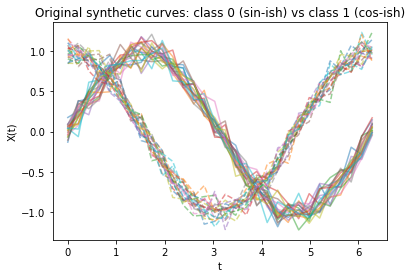

In [6]:
# Visualize the original synthetic data
import matplotlib.pyplot as plt
import numpy as np
import torch

# X: [40, 30], grid: [30], labels: [40]

plt.figure()
for i in range(len(X)):
    if labels[i] == 0:
        plt.plot(grid.numpy(), X[i].numpy(), alpha=0.5)  # class 0
    else:
        plt.plot(grid.numpy(), X[i].numpy(), alpha=0.5, linestyle="--")  # class 1

plt.xlabel("t")
plt.ylabel("X(t)")
plt.title("Original synthetic curves: class 0 (sin-ish) vs class 1 (cos-ish)")
plt.show()


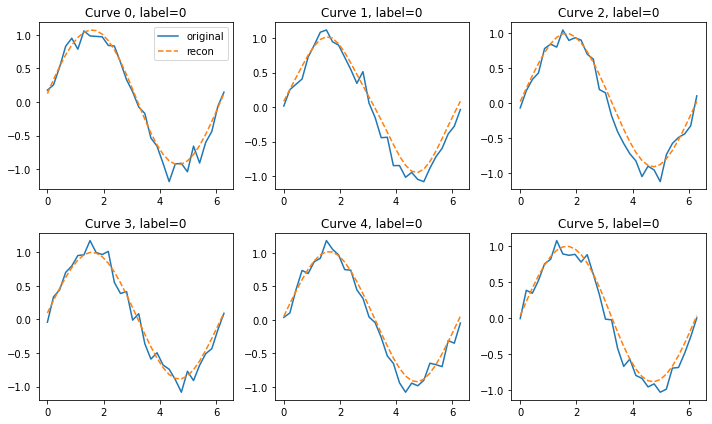

In [7]:
# Visualize reconstructions vs originals
extras = history_test["extras"]
model = extras["model"]
tpts = extras["tpts"]
basis_fc_project = extras["basis_fc_project"]
basis_fc_revert = extras["basis_fc_revert"]
device = extras["device"]
recon_loss_fn = extras["recon_loss_fn"]

model.eval()
with torch.no_grad():
    X_dev = X.to(device).float()
    x_hat, rep, feature, coef, logits = model(
        X_dev, tpts, basis_fc_project, basis_fc_revert
    )

x_hat_np = x_hat.cpu().numpy()

# Plot a few examples
n_show = 6
plt.figure(figsize=(10, 6))
for k in range(n_show):
    plt.subplot(2, 3, k+1)
    plt.plot(grid.numpy(), X[k].numpy(), label="original")
    plt.plot(grid.numpy(), x_hat_np[k], linestyle="--", label="recon")
    plt.title(f"Curve {k}, label={labels[k]}")
    if k == 0:
        plt.legend()

plt.tight_layout()
plt.show()

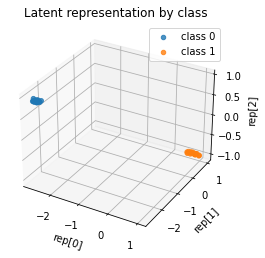

In [8]:
# The latent representation (encoder output) and classification
rep_np = rep.cpu().numpy()  # [40, 3]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for c in np.unique(labels):
    mask = labels == c
    ax.scatter(
        rep_np[mask, 0],
        rep_np[mask, 1],
        rep_np[mask, 2],
        label=f"class {c}",
        alpha=0.8,
    )

ax.set_xlabel("rep[0]")
ax.set_ylabel("rep[1]")
ax.set_zlabel("rep[2]")
ax.set_title("Latent representation by class")
ax.legend()
plt.show()

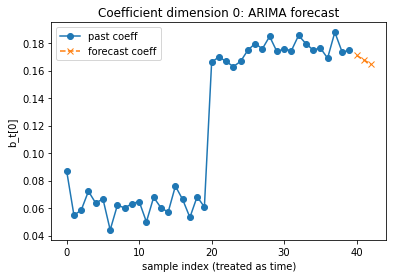

In [ ]:
# Coefficient time series and ARIMA forecasts
coef_past      = forecast_test["coef_past"]      # [40, 6]
coef_forecast  = forecast_test["coef_forecast"]  # [3, 6]
curve_forecast = forecast_test["curve_forecast"] # [3, 30]

coef_past = forecast_test["coef_past"]
coef_forecast = forecast_test["coef_forecast"]

m = 0  # coefficient index to visualize
time_past = np.arange(coef_past.shape[0])        # 0..39
time_future = np.arange(coef_past.shape[0], coef_past.shape[0] + coef_forecast.shape[0])  # 40..42

plt.figure()
plt.plot(time_past, coef_past[:, m], marker="o", label="past coeff")
plt.plot(time_future, coef_forecast[:, m], marker="x", linestyle="--", label="forecast coeff")
plt.xlabel("sample index (treated as time)")
plt.ylabel(f"b_t[{m}]")
plt.title(f"Coefficient dimension {m}: ARIMA forecast")
plt.legend()
plt.show()


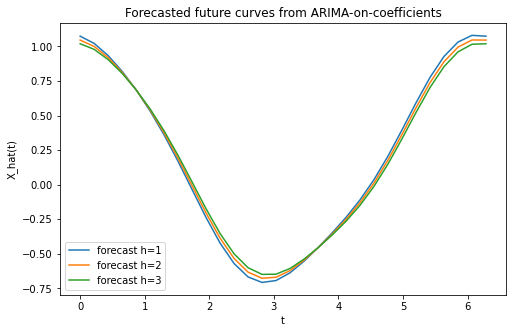

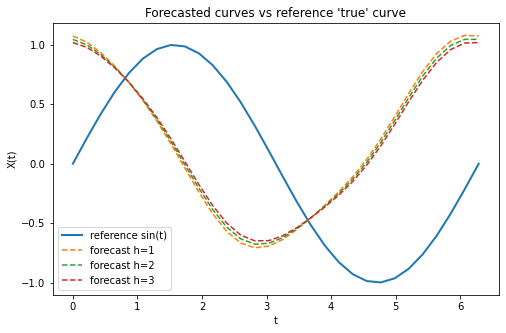

In [12]:
# Visualize the forecasted curves themselves
curve_forecast = forecast_test["curve_forecast"]  # [3, 30]

plt.figure(figsize=(8, 5))
for h in range(curve_forecast.shape[0]):
    plt.plot(grid.numpy(), curve_forecast[h], label=f"forecast h={h+1}")

plt.xlabel("t")
plt.ylabel("X_hat(t)")
plt.title("Forecasted future curves from ARIMA-on-coefficients")
plt.legend()
plt.show()

# just a rough "ideal" continuation: alternate between sin and cos, or pick one
true_like = np.sin(grid.numpy())  # for example

plt.figure(figsize=(8,5))
plt.plot(grid.numpy(), true_like, label="reference sin(t)", linewidth=2)
for h in range(curve_forecast.shape[0]):
    plt.plot(grid.numpy(), curve_forecast[h], linestyle="--", label=f"forecast h={h+1}")

plt.xlabel("t")
plt.ylabel("X(t)")
plt.title("Forecasted curves vs reference 'true' curve")
plt.legend()
plt.show()
